In [1]:
script = False
cluster = False

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

import seaborn as sn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from PIL import Image, ImageOps
#from transformers import ViTFeatureExtractor, ViTForImageClassification

from memory_profiler import memory_usage
import random
import os
import gc
from astropy.io import fits

from skimage import io
import matplotlib.pyplot as plt

if(script):
    from tqdm import tqdm
else: 
    from tqdm.notebook import tqdm

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        """
        #Plotting with Astropy and saving as png (not used right now)
        print('Astropy')
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.savefig('Image.png', bbox_inches='tight')
        plt.close()
        new_image = Image.open('Image.png')
        return(new_image)
        """
        #new_image = np.empty((3, 46, 46)) #I NEED TO CHANGE MY IMAGE SIZES!!!!!!
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [5]:
seed_everything(9)

if(cluster):
    path = '/data/des90.a/data/sgonzal/training_data/' #DES cluster
    path = '' #CHTC
else:
    path = 'Data/' #local
    
#10420, 4000, 164, 199, 1000, 223, 2000, 2000, 1500, 2500, 500
npos, nred, ngz2, nn10, nround, nmergers = 10, 10, 10, 10, 10, 10
nspirals, nellip, nothers, nrandom, nerrors = 10, 10, 10, 10, 10
num_workers = 0
num_epochs = 1


hdu_list = fits.open(path + '45.fits')
idx = random.sample(range(len(hdu_list[1].data)), npos)
images_pos = hdu_list[1].data[idx,:] 
data_pos = pd.DataFrame(hdu_list[2].data[:][idx])
data_pos = data_pos.drop('TILENAME', axis=1)
labels_pos = np.zeros(npos, dtype = np.int64)
hdu_list.close()

hdu_list = fits.open(path + 'negative_redmagic.fits')
idx = random.sample(range(len(hdu_list[1].data)), nred)
images_neg1 = hdu_list[1].data[idx,:] 
images_neg1 = images_neg1[:,0:3,:,:]
labels_neg1 = np.ones(nred, dtype = np.int64)
#Data for negatives, all null
num_columns = len(data_pos.columns)
data_neg1 = np.full((nred, num_columns), 0)
data_neg1 = pd.DataFrame(data_neg1, columns=data_pos.columns)
hdu_list.close()

hdu_list = fits.open(path + 'bar_gz2.fits')
idx = random.sample(range(len(hdu_list[1].data)), ngz2)
images_neg2 = hdu_list[1].data[idx,:] 
images_neg2 = images_neg2[:,0:3,:,:]
labels_neg2 = np.ones(ngz2, dtype = np.int64)
#Data for negatives, all null
data_neg2 = np.full((ngz2, num_columns), 0)
data_neg2 = pd.DataFrame(data_neg2, columns=data_pos.columns)
hdu_list.close()

hdu_list = fits.open(path + 'bar_n10.fits')
idx = random.sample(range(len(hdu_list[1].data)), nn10)
images_neg3 = hdu_list[1].data[idx,:] 
images_neg3 = images_neg3[:,0:3,:,:]
labels_neg3 = np.ones(nn10, dtype = np.int64)
#Data for negatives, all null
data_neg3 = np.full((nn10, num_columns), 0)
data_neg3 = pd.DataFrame(data_neg3, columns=data_pos.columns)
hdu_list.close()

hdu_list = fits.open(path + 'round.fits')
idx = random.sample(range(len(hdu_list[1].data)), nround)
images_neg4 = hdu_list[1].data[idx,:] 
images_neg4 = images_neg4[:,0:3,:,:]
labels_neg4 = np.ones(nround, dtype = np.int64)
#Data for negatives, all null
data_neg4 = np.full((nround, num_columns), 0)
data_neg4 = pd.DataFrame(data_neg4, columns=data_pos.columns)
hdu_list.close()

hdu_list = fits.open(path + 'mergers.fits')
idx = random.sample(range(len(hdu_list[1].data)), nmergers)
images_neg5 = hdu_list[1].data[idx,:] 
images_neg5 = images_neg5[:,0:3,:,:]
labels_neg5 = np.ones(nmergers, dtype = np.int64)
#Data for negatives, all null
data_neg5 = np.full((nmergers, num_columns), 0)
data_neg5 = pd.DataFrame(data_neg5, columns=data_pos.columns)
hdu_list.close()

hdu_list = fits.open(path + 'des_spirals.fits')
idx = random.sample(range(len(hdu_list[1].data)), nspirals)
images_neg6 = hdu_list[1].data[idx,:] 
images_neg6 = images_neg6[:,0:3,:,:]
labels_neg6 = np.ones(nspirals, dtype = np.int64)
#Data for negatives, all null
data_neg6 = np.full((nspirals, num_columns), 0)
data_neg6 = pd.DataFrame(data_neg6, columns=data_pos.columns)
hdu_list.close()

hdu_list = fits.open(path + 'des_ellipticals.fits')
idx = random.sample(range(len(hdu_list[1].data)), nellip)
images_neg7 = hdu_list[1].data[idx,:] 
images_neg7 = images_neg7[:,0:3,:,:]
labels_neg7 = np.ones(nellip, dtype = np.int64)
#Data for negatives, all null
data_neg7 = np.full((nellip, num_columns), 0)
data_neg7 = pd.DataFrame(data_neg7, columns=data_pos.columns)
hdu_list.close()

hdu_list = fits.open(path + 'des_others.fits')
idx = random.sample(range(len(hdu_list[1].data)), nothers)
images_neg8 = hdu_list[1].data[idx,:] 
images_neg8 = images_neg8[:,0:3,:,:]
labels_neg8 = np.ones(nothers, dtype = np.int64)
#Data for negatives, all null
data_neg8 = np.full((nothers, num_columns), 0)
data_neg8 = pd.DataFrame(data_neg8, columns=data_pos.columns)
hdu_list.close()

hdu_list = fits.open(path + 'negative_othergalaxies.fits')
idx = random.sample(range(len(hdu_list[1].data)), nrandom)
images_neg9 = hdu_list[1].data[idx,:] 
images_neg9 = images_neg9[:,0:3,:,:]
labels_neg9 = np.ones(nrandom, dtype = np.int64)
#Data for negatives, all null
data_neg9 = np.full((nrandom, num_columns), 0)
data_neg9 = pd.DataFrame(data_neg9, columns=data_pos.columns)
hdu_list.close()

hdu_list = fits.open(path + 'errors.fits')
idx = random.sample(range(len(hdu_list[1].data)), nerrors)
images_neg10 = hdu_list[1].data[idx,:] 
images_neg10 = images_neg10[:,0:3,:,:]
labels_neg10 = np.ones(nerrors, dtype = np.int64)
#Data for negatives, all null
data_neg10 = np.full((nerrors, num_columns), 0)
data_neg10 = pd.DataFrame(data_neg10, columns=data_pos.columns)
hdu_list.close()

images_dataset = np.concatenate((images_pos, images_neg1, images_neg2, images_neg3, images_neg4, 
                                 images_neg5, images_neg6, images_neg7, images_neg8, images_neg9, images_neg10)).astype(np.float32)
data_dataset = pd.concat([data_pos, data_neg1, data_neg2, data_neg3, data_neg4, data_neg5, data_neg6,
                         data_neg7, data_neg8, data_neg9, data_neg10], axis=0).reset_index(drop=True)
labels_dataset = np.concatenate((labels_pos, labels_neg1, labels_neg2, labels_neg3, labels_neg4, labels_neg5,
                                labels_neg6, labels_neg7, labels_neg8, labels_neg9, labels_neg10), dtype = np.int64)

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

print(images_dataset.shape)

(110, 3, 45, 45)


In [6]:
train_dataset, other_dataset = make_train_test_datasets(images_dataset, data_dataset, labels_dataset, test_size=0.3, transform=transform)
valid_dataset, test_dataset = make_train_test_datasets(other_dataset.images, other_dataset.data, other_dataset.labels, test_size=0.5, transform=transform)
print('Len train dataset: {}, len test dataset: {}'.format(len(train_dataset), len(test_dataset)))

Len train dataset: 77, len test dataset: 17


In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=20, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=20, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, num_workers=num_workers, shuffle=True)
torch.save(test_loader, 'test_loader.pth')

In [8]:
#model = timm.create_model("vit_base_patch16_224", pretrained=True)
#path = 'jx_vit_base_p16_224-80ecf9dd.pth'
#model.load_state_dict(torch.load(path))

In [9]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        #self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.model = timm.create_model("vit_base_patch16_224")
        if(pretrained):
            path = 'jx_vit_base_p16_224-80ecf9dd.pth'
            self.model.load_state_dict(torch.load(path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):

        x = self.model(x)

        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################

        self.model.train()

        #for i, (data, target, sample_img, sample_data) in tqdm(enumerate(train_loader)):
        for i, sample in enumerate(tqdm(train_loader)):

            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            #output = torch.squeeze(output)

            #target = target.float()
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Calculate Accuracy
            #accuracy = (output.argmax(dim=1) == target).float().mean()
            accuracy = sum(output.argmax(dim=1) == target)
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            optimizer.step()

        return epoch_loss / len(train_loader.dataset), epoch_accuracy / len(train_loader.dataset)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for i, sample in enumerate(tqdm(valid_loader)):
            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                #accuracy = (output.argmax(dim=1) == target).float().mean()
                accuracy = sum(output.argmax(dim=1) == target)
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader.dataset), valid_accuracy / len(valid_loader.dataset)

In [10]:
model = ViTBase16(n_classes=2, pretrained=True)

criterion = nn.CrossEntropyLoss() #nn.CrossEntropyLoss() #nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cpu


In [11]:
def fit_tpu(model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    
    best_val_acc = 0.0 # track of best accuracy

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        
        print(f"{'=' * 100}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        # moves towards valid_loader
        print("start valid_loader")

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            if(valid_acc > best_val_acc):
                setattr(model, 'loss_train', train_losses)
                setattr(model, 'loss_valid', valid_losses)
                setattr(model, 'train_acc', train_accs)
                setattr(model, 'validation_acc', valid_accs)
                torch.save(model, name_model)
                best_val_acc = valid_acc

In [12]:
def plot_performance(cnn):
    loss_train = [x.item() for x in cnn.loss_train]
    loss_valid = [x.item() for x in cnn.loss_valid]
    train_acc = [x.item() for x in cnn.train_acc]
    valid_acc = [x.item() for x in cnn.validation_acc]
    
    x = np.linspace(1,len(cnn.loss_train),len(cnn.loss_train))
    fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
    
    ax1.set_title('Losses')
    ax1.set_xlabel('Epoch')
    ax1.scatter(x, loss_train, color = 'skyblue', alpha = 0.8, label = 'Training loss')
    ax1.scatter(x, loss_valid, color = 'limegreen', alpha = 0.8,  label = 'Validation loss')
    ax1.legend()
    
    ax2.set_title('Performance. Max: {:.4f}%'.format(100*cnn.validation_acc[-1].item()))
    ax2.set_xlabel('Epoch')
    ax2.scatter(x, train_acc, color = 'skyblue', alpha = 0.8,  label = 'Training Accuracy')
    ax2.scatter(x, valid_acc, color = 'limegreen', alpha = 0.8,  label = 'Validation Accuracy')
    ax2.legend()
    
    if(script):
        plt.savefig('Performance.png', bbox_inches='tight')
        plt.close()
    else: 
        plt.show(block=True)
    

In [13]:
name_model = 'model.pt'
#                          model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
mem_usage = memory_usage(( fit_tpu, (model, name_model, num_epochs, device, criterion, optimizer, train_loader, valid_loader)))


EPOCH 1 - TRAINING...


  0%|          | 0/4 [00:00<?, ?it/s]


	[TRAIN] EPOCH 1 - LOSS: 0.01948457583785057, ACCURACY: 0.7922077775001526

start valid_loader
EPOCH 1 - VALIDATING...


  0%|          | 0/1 [00:00<?, ?it/s]

	[VALID] LOSS: 0.009458730928599834, ACCURACY: 0.9375



In [14]:
print('Maximum memory usage: %s' % max(mem_usage))

Maximum memory usage: 3289.3203125


In [15]:
name = 'model.pt'#'model.pt'#'other.pt' 
model = torch.load(name)
print('Maximum validation accuracy: {:.2f}%'.format(100*model.validation_acc[-1].item()))

Maximum validation accuracy: 93.75%


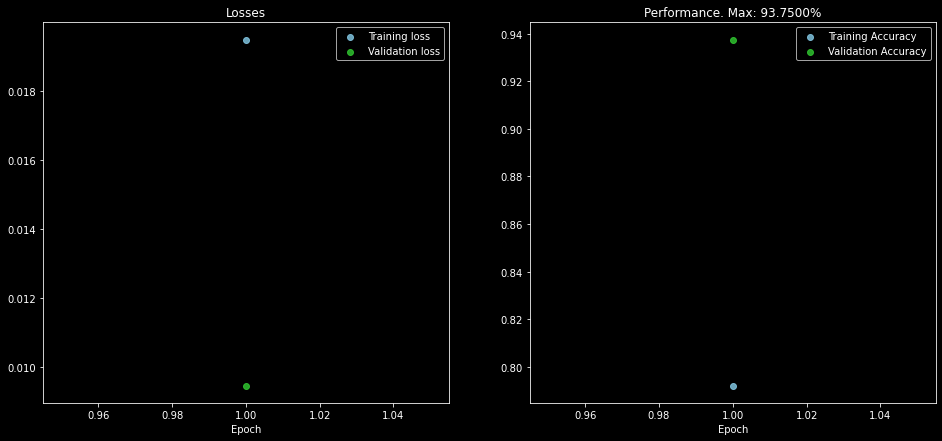

In [16]:
plot_performance(model)

In [17]:
def testing_analysis(prob_lim, test_loader):
    right_pos_img, wrong_pos_img = np.zeros((1,3,45,45)), np.zeros((1,3,45,45))
    right_neg_img, wrong_neg_img = np.zeros((1,3,45,45)), np.zeros((1,3,45,45))
    columns = ['Prob', 'Z_LENS', 'FLUX_RADIUS_G', 'FLUX_RADIUS_R',
       'FLUX_RADIUS_I', 'FLUX_RADIUS_Z', 'MAG_APER_4_G', 'MAG_APER_8_G', 'LUM',
       'FWHM_WMEAN_G', 'FWHM_WMEAN_R', 'FWHM_WMEAN_I', 'FWHM_WMEAN_Z',
       'SKYBRITE_WMEAN_G', 'SKYBRITE_WMEAN_R', 'SKYBRITE_WMEAN_I',
       'SKYBRITE_WMEAN_Z', 'Z1', 'LENSED_MAG', 'mag_1', 'ISOLATION',
       'EINSTEIN_RADIUS', 'MAGNIFICATION']# COLUMNS + PROB
    prob_list, true_list, pred_list = [], [], []
    right_pos, wrong_pos = pd.DataFrame(columns=columns), pd.DataFrame(columns=columns)
    right_neg, wrong_neg = pd.DataFrame(columns=columns), pd.DataFrame(columns=columns)

    for i_batch, sample in enumerate(tqdm(test_loader)):
        sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
        
        if device.type == "cuda":
            sample_image, sample_label = sample_image.cuda(), sample_label.cuda()
        
        output = model(sample_image)
        predicted = output.argmax(dim=1).item()
        my_df = pd.DataFrame.from_dict(sample_data)
    
        prob = nn.Softmax(dim=1)(output)
        prob = prob[:,0].detach().cpu().numpy()[0]
        predicted = 0 if prob >= prob_lim else 1
        
        prob_list.append(prob)
        true_list.append(sample_label.item())
        pred_list.append(predicted)
    
        new_df = pd.DataFrame.from_dict(sample_data)
        new_df['Prob'] = prob
    
        if(sample_label.item() == 0 and predicted == 0):
            right_pos_img = np.append(right_pos_img, [np.array(sample_img[0])], axis = 0)
            right_pos = right_pos.append(new_df, ignore_index=True)
        elif(sample_label.item() == 0 and predicted == 1):
            wrong_pos_img = np.append(wrong_pos_img, [np.array(sample_img[0])], axis = 0)
            wrong_pos = wrong_pos.append(new_df, ignore_index=True)
        if(sample_label.item() == 1 and predicted == 1): 
            right_neg_img = np.append(right_neg_img, [np.array(sample_img[0])], axis = 0)
            right_neg = right_neg.append(new_df, ignore_index=True)
        elif(sample_label.item() == 1 and predicted == 0): 
            wrong_neg_img = np.append(wrong_neg_img, [np.array(sample_img[0])], axis = 0)
            wrong_neg = wrong_neg.append(new_df, ignore_index=True)
    
    
    right_pos_img = np.delete(right_pos_img, 0, axis = 0)
    wrong_pos_img = np.delete(wrong_pos_img, 0, axis = 0)
    right_neg_img = np.delete(right_neg_img, 0, axis = 0)
    wrong_neg_img = np.delete(wrong_neg_img, 0, axis = 0)
    
    FPR = len(wrong_neg_img)/(len(wrong_neg_img) + len(right_neg_img))*100
    TPR = len(right_pos_img)/(len(right_pos_img) + len(wrong_pos_img))*100
    
    images = [right_pos_img, wrong_pos_img, right_neg_img, wrong_neg_img]
    data = [right_pos, wrong_pos, right_neg, wrong_neg]
    rates = [FPR, TPR]
    lists = [prob_list, true_list, pred_list]
    
    return(images, data, rates, lists)


In [18]:
prob_lim = 0.5

names = ['Prob', 'Z_LENS', 'FLUX_RADIUS_G', 'FLUX_RADIUS_R',
       'FLUX_RADIUS_I', 'FLUX_RADIUS_Z', 'MAG_APER_4_G', 'MAG_APER_8_G', 'LUM',
       'FWHM_WMEAN_G', 'FWHM_WMEAN_R', 'FWHM_WMEAN_I', 'FWHM_WMEAN_Z',
       'SKYBRITE_WMEAN_G', 'SKYBRITE_WMEAN_R', 'SKYBRITE_WMEAN_I',
       'SKYBRITE_WMEAN_Z', 'Z1', 'LENSED_MAG', 'mag_1', 'ISOLATION',
       'EINSTEIN_RADIUS', 'MAGNIFICATION']
test_loader = torch.load('test_loader.pth') #'exp_36_24000/test_loader.pth'
if(script == False): test_loader.num_workers = 0
images, data, rates, lists = testing_analysis(prob_lim, test_loader)
right_pos_img, wrong_pos_img, right_neg_img, wrong_neg_img = images[0], images[1], images[2], images[3]
right_pos, wrong_pos, right_neg, wrong_neg = data[0], data[1], data[2], data[3]
FPR, TPR = rates[0], rates[1]
prob_list, true_list, pred_list = lists[0], lists[1], lists[2]
conf_matrix = confusion_matrix(true_list, pred_list, labels = [0, 1])
if(script):
    right_pos.to_csv('data_right_pos.csv')
    wrong_pos.to_csv('data_wrong_pos.csv')

  0%|          | 0/17 [00:00<?, ?it/s]

In [19]:
def make_plot_all(objects, title, data):
    #print(title)
    for i in range(len(objects)):
        if(i%4 == 0):
            plt.figure(figsize=(12,8))
            for j in range(4):
                if(i+j > len(objects)-1): break
                plt.subplot(1,4,j+1)
                new_title = 'Prob: {:.2f}'.format(data['Prob'][i+j])
                plt.title(new_title)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            if(script):
                plt.savefig(title+'_'+ str(i+j) + '.png', bbox_inches='tight')
                plt.close()
            else: 
                plt.show()

def plot_confusion_matrix():
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (9,6))
    plt.title('Confusion Matrix')
    #sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap='magma', annot=True, linecolor='w', linewidths=.5, annot_kws={"size": 14})
    if(script):
        plt.savefig('Confusion_matrix.png', bbox_inches='tight')
        plt.close()
    else: 
        plt.show()

def prob_distribution(prob_list):
    plt.figure(figsize=(10,6))
    plt.title('Probability labeled as Positive')
    plt.hist(prob_list, 100, color = "skyblue")
    if(script):
        plt.savefig('Prob_Pos Distribution.png', bbox_inches='tight')
        plt.close()
    else: 
        plt.show()
        
def ROC_curve(num_points):
    prob_lim = np.linspace(0, 1., num_points)
    df = pd.DataFrame()
    df['Prob'] = prob_list
    df['True'] = true_list
    FPR_list, TPR_list = [], []
    print('Prob, FPR, TPR')
    for i in range(len(prob_lim)):
        df['Pred'] = [1]*len(true_list)
        df.loc[df['Prob'] > prob_lim[i], 'Pred'] = 0
        rp = df[(df['True'] == 0) & (df['Pred'] == df['True'])]
        rn = df[(df['True'] == 1) & (df['Pred'] == df['True'])]
        wp = df[(df['True'] == 0) & (df['Pred'] != df['True'])]
        wn = df[(df['True'] == 1) & (df['Pred'] != df['True'])]
        FPR = len(wn)/(len(wn) + len(rn))*100
        TPR = len(rp)/(len(rp) + len(wp))*100
        FPR_list.append(FPR)
        TPR_list.append(TPR)
        print('{:.2f}, {:.2f}, {:.2f}'.format(prob_lim[i], FPR, TPR))
    
    plt.figure(figsize=(8,6))
    plt.title('ROC curve')
    plt.plot(FPR_list, TPR_list, 'o')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if(script):
        plt.savefig('ROC_curve', bbox_inches='tight')
        plt.close()
    else:
        plt.show()

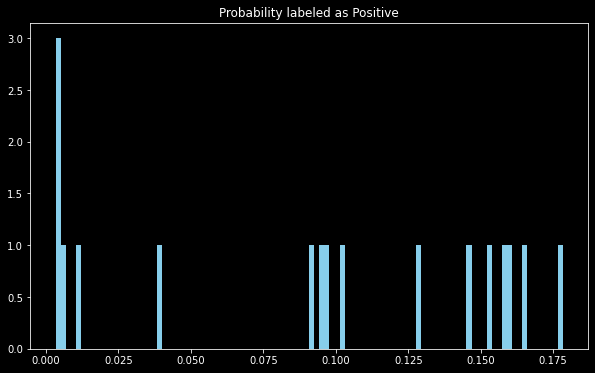

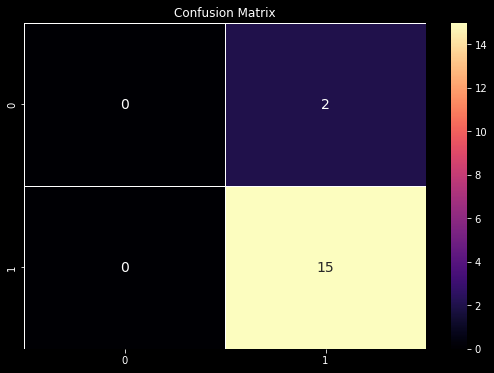

Prob, FPR, TPR
0.00, 100.00, 100.00
0.02, 66.67, 100.00
0.04, 60.00, 100.00
0.06, 60.00, 100.00
0.08, 60.00, 100.00
0.10, 46.67, 50.00
0.12, 46.67, 0.00
0.14, 40.00, 0.00
0.16, 13.33, 0.00
0.18, 0.00, 0.00
0.20, 0.00, 0.00
0.22, 0.00, 0.00
0.24, 0.00, 0.00
0.27, 0.00, 0.00
0.29, 0.00, 0.00
0.31, 0.00, 0.00
0.33, 0.00, 0.00
0.35, 0.00, 0.00
0.37, 0.00, 0.00
0.39, 0.00, 0.00
0.41, 0.00, 0.00
0.43, 0.00, 0.00
0.45, 0.00, 0.00
0.47, 0.00, 0.00
0.49, 0.00, 0.00
0.51, 0.00, 0.00
0.53, 0.00, 0.00
0.55, 0.00, 0.00
0.57, 0.00, 0.00
0.59, 0.00, 0.00
0.61, 0.00, 0.00
0.63, 0.00, 0.00
0.65, 0.00, 0.00
0.67, 0.00, 0.00
0.69, 0.00, 0.00
0.71, 0.00, 0.00
0.73, 0.00, 0.00
0.76, 0.00, 0.00
0.78, 0.00, 0.00
0.80, 0.00, 0.00
0.82, 0.00, 0.00
0.84, 0.00, 0.00
0.86, 0.00, 0.00
0.88, 0.00, 0.00
0.90, 0.00, 0.00
0.92, 0.00, 0.00
0.94, 0.00, 0.00
0.96, 0.00, 0.00
0.98, 0.00, 0.00
1.00, 0.00, 0.00


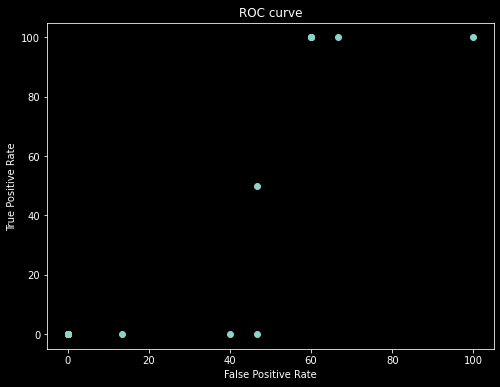

In [20]:
prob_distribution(prob_list)
plot_confusion_matrix()
ROC_curve(50)

In [21]:
print('Right positives: ' + str(right_pos_img.shape))
print('Wrong positives: ' + str(wrong_pos_img.shape))
print('Right negatives: ' + str(right_neg_img.shape))
print('Wrong negatives: ' + str(wrong_neg_img.shape))
print('Accuracy: {:.2f}%'.format( 100*(len(right_pos_img)+len(right_neg_img)) /len(test_dataset)))
print('Area Under Curve: {:.3f}'.format(1-roc_auc_score(true_list, prob_list)))
print('True positive rate: {:.2f}%'.format(TPR))
print('False positive rate: {:.2f}%'.format(FPR))
print('Mean prob. right positives: {:.3f}'.format(np.mean(right_pos['Prob'])))
print('Mean prob. wrong positives: {:.3f}'.format(np.mean(wrong_pos['Prob'])))
print('Mean prob. right negatives: {:.3f}'.format(np.mean(right_neg['Prob'])))
print('Mean prob. wrong negatives: {:.3f}'.format(np.mean(wrong_neg['Prob'])))

Right positives: (0, 3, 45, 45)
Wrong positives: (2, 3, 45, 45)
Right negatives: (15, 3, 45, 45)
Wrong negatives: (0, 3, 45, 45)
Accuracy: 88.24%
Area Under Curve: 0.533
True positive rate: 0.00%
False positive rate: 0.00%
Mean prob. right positives: nan
Mean prob. wrong positives: 0.100
Mean prob. right negatives: 0.090
Mean prob. wrong negatives: nan


In [22]:
def make_histo(name):
    plt.figure(figsize=(16,5)) 

    plt.subplot(1,2,1)
    plt.title('All distribution: ' + str(name))
    data_all = np.concatenate((right_pos[name], wrong_pos[name]))
    plt.hist(data_all, density = True, bins = 'auto', edgecolor = 'black')
    
    
    plt.subplot(1,2,2)
    plt.title(name)
    weights = np.ones_like(right_pos[name]) / len(right_pos[name])
    plt.hist(right_pos[name], density = True, bins = 'auto', color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
    plt.hist(wrong_pos[name], density = True, bins = 'auto', color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
    plt.legend()
    
    if(script):
        plt.savefig('Histogram_' + str(name), bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
def histo_ratio(name, var1, var2):
    plt.figure(figsize=(16,5)) 

    plt.subplot(1,2,1)
    plt.title('All distribution: ' + var1 + '/' + var2)
    data_all = np.concatenate((right_pos[var1]/right_pos[var2], wrong_pos[var1]/wrong_pos[var2]))
    plt.hist(data_all, density = True, bins = 'auto', edgecolor = 'black')
    
    plt.subplot(1,2,2)
    plt.title(var1 + '/' + var2)
    plt.hist(right_pos[var1]/right_pos[var2], density = True, bins = 'auto', color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
    plt.hist(wrong_pos[var1]/wrong_pos[var2], density = True, bins = 'auto', color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
    plt.legend()
    
    if(script):
        plt.savefig('Histogram_' + str(name), bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
def make_all_histos():
    for name in names:
        make_histo(name)
    histo_ratio('Z1_ZLENS', 'Z1', 'Z_LENS')
    histo_ratio('E_FluxR', 'EINSTEIN_RADIUS', 'FLUX_RADIUS_G')

In [23]:
def make_prob_vs(name):
    plt.figure(figsize=(14,6)) 
    plt.title(name)
    plt.xlabel('Prob labeled as Single')
    plt.ylabel(name)
    plt.plot(right_pos['Prob'], right_pos[name], 'o', color = 'skyblue', label='right')
    plt.plot(wrong_pos['Prob'], wrong_pos[name], 'o', color = 'violet', label='wrong')
    plt.legend()

    if(script):
        plt.savefig('Prob_vs_' + str(name), bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
def make_all_prob_vs():
    for name in names:
        if(name == 'Prob'): continue
        make_prob_vs(name)

In [24]:
def make_plots_correlation():
    
    plt.figure(figsize=(16,30)) 

    plt.subplot(5,2,1)
    plt.xlabel(names[1])
    plt.ylabel(names[17])
    plt.scatter(right_pos[names[1]], right_pos[names[17]], color = 'blueviolet', alpha = 0.6, label ='Right')
    plt.scatter(wrong_pos[names[1]], wrong_pos[names[17]], color = 'cyan', alpha = 0.7, label = 'Wrong')
    plt.legend()

    plt.subplot(5,2,2)
    plt.xlabel(names[22])
    plt.ylabel(names[18])
    plt.scatter(right_pos[names[22]], right_pos[names[18]], color = 'blueviolet', alpha = 0.6, label ='Right')
    plt.scatter(wrong_pos[names[22]], wrong_pos[names[18]], color = 'cyan', alpha = 0.7, label = 'Wrong')
    plt.legend()

    plt.subplot(5,2,3)
    plt.xlabel(names[22])
    plt.ylabel(names[20])
    plt.scatter(right_pos[names[22]], right_pos[names[20]], color = 'blueviolet', alpha = 0.6, label ='Right')
    plt.scatter(wrong_pos[names[22]], wrong_pos[names[20]], color = 'cyan', alpha = 0.7, label = 'Wrong')
    plt.legend()

    plt.subplot(5,2,4)
    plt.xlabel(names[22])
    plt.ylabel(names[21])
    plt.scatter(right_pos[names[22]], right_pos[names[21]], color = 'blueviolet', alpha = 0.6, label ='Right')
    plt.scatter(wrong_pos[names[22]], wrong_pos[names[21]], color = 'cyan', alpha = 0.7, label = 'Wrong')
    plt.legend()

    plt.subplot(5,2,5)
    plt.xlabel(names[20])
    plt.ylabel(names[18])
    plt.scatter(right_pos[names[20]], right_pos[names[18]], color = 'blueviolet', alpha = 0.6, label ='Right')
    plt.scatter(wrong_pos[names[20]], wrong_pos[names[18]], color = 'cyan', alpha = 0.7, label = 'Wrong')
    plt.legend()

    plt.subplot(5,2,6)
    plt.xlabel(names[20])
    plt.ylabel(names[21])
    plt.scatter(right_pos[names[20]], right_pos[names[21]], color = 'blueviolet', alpha = 0.6, label ='Right')
    plt.scatter(wrong_pos[names[20]], wrong_pos[names[21]], color = 'cyan', alpha = 0.7, label = 'Wrong')
    plt.legend()

    plt.subplot(5,2,7)
    plt.xlabel(names[17] + '/' + names[1])
    plt.ylabel(names[21] + '/' + names[2])
    plt.scatter(right_pos[names[17]]/right_pos[names[1]], right_pos[names[21]]/right_pos[names[2]], color = 'blueviolet', alpha = 0.6, label ='Right')
    plt.scatter(wrong_pos[names[17]]/wrong_pos[names[1]], wrong_pos[names[21]]/wrong_pos[names[2]], color = 'cyan', alpha = 0.7, label = 'Wrong')
    plt.legend()

    plt.subplot(5,2,8)
    plt.xlabel(names[8])
    plt.ylabel(names[21] + '/' + names[2])
    plt.scatter(right_pos[names[8]], right_pos[names[21]]/right_pos[names[2]], color = 'blueviolet', alpha = 0.6, label ='Right')
    plt.scatter(wrong_pos[names[8]], wrong_pos[names[21]]/wrong_pos[names[2]], color = 'cyan', alpha = 0.7, label = 'Wrong')
    plt.legend()

    plt.subplot(5,2,9)
    plt.xlabel(names[9])
    plt.ylabel(names[13])
    plt.scatter(right_pos[names[9]], right_pos[names[13]], color = 'blueviolet', alpha = 0.6, label ='Right')
    plt.scatter(wrong_pos[names[9]], wrong_pos[names[13]], color = 'cyan', alpha = 0.7, label = 'Wrong')
    plt.legend()

    plt.subplot(5,2,10)
    plt.xlabel(names[13])
    plt.ylabel(names[21] + '/' + names[2])
    plt.scatter(right_pos[names[13]], right_pos[names[21]]/right_pos[names[2]], color = 'blueviolet', alpha = 0.6, label ='Right')
    plt.scatter(wrong_pos[names[13]], wrong_pos[names[21]]/wrong_pos[names[2]], color = 'cyan', alpha = 0.7, label = 'Wrong')
    plt.legend()
    
    if(script):
        plt.savefig('Plots_correlation', bbox_inches='tight')
        plt.close()
    else:
        plt.show()

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


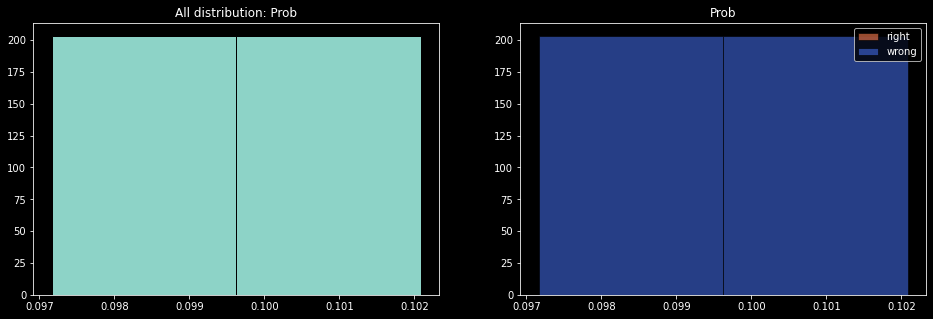

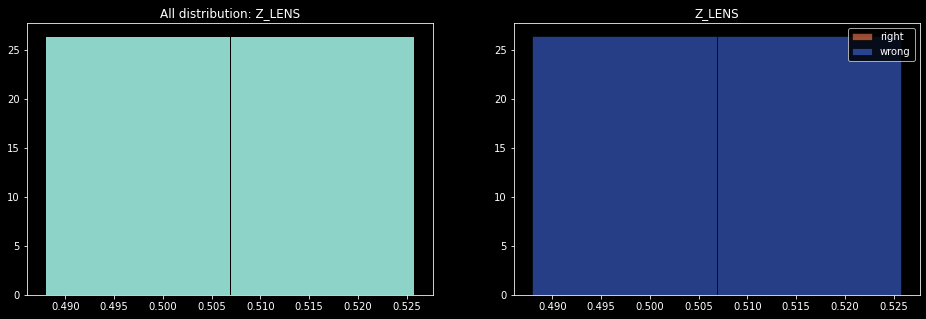

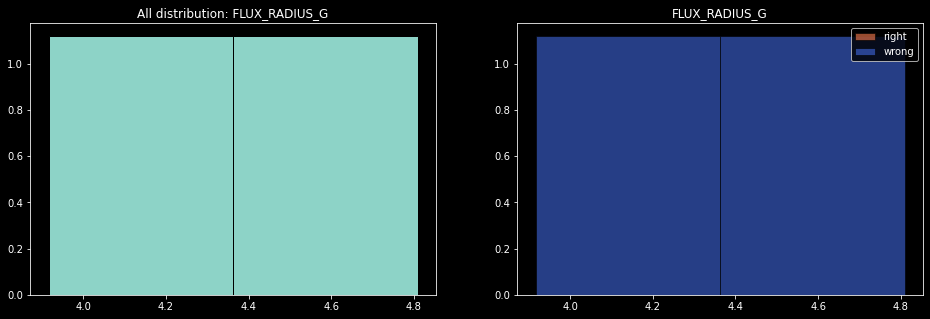

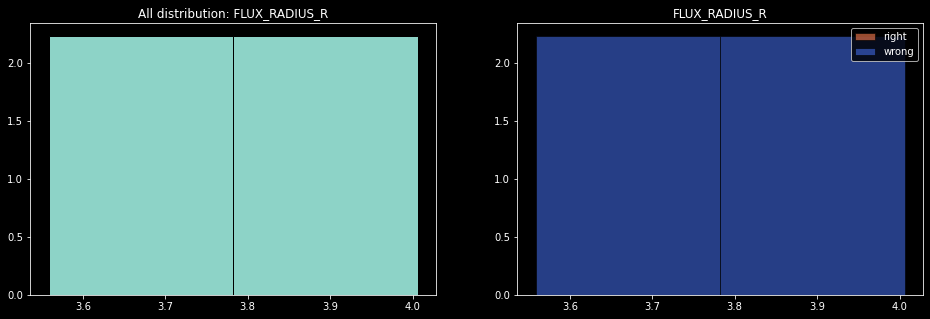

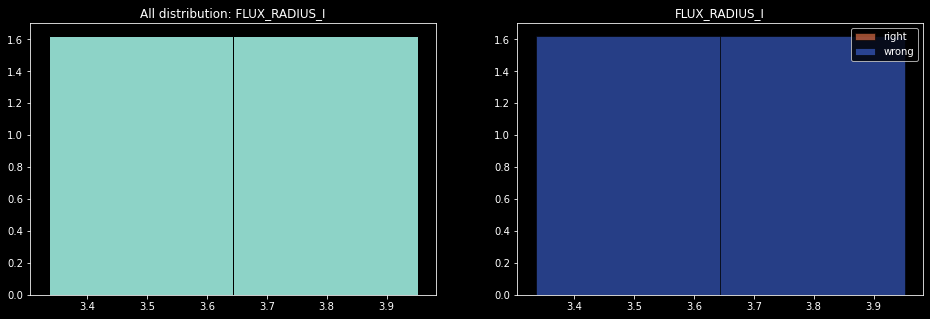

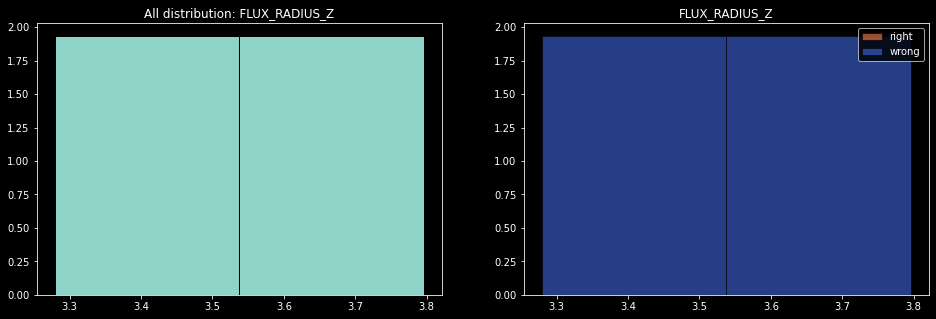

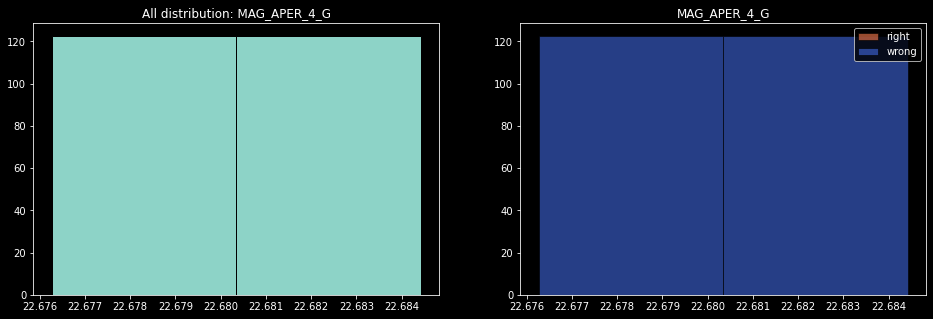

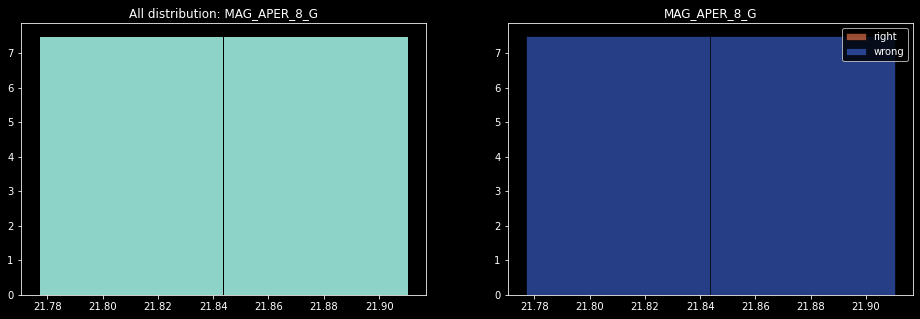

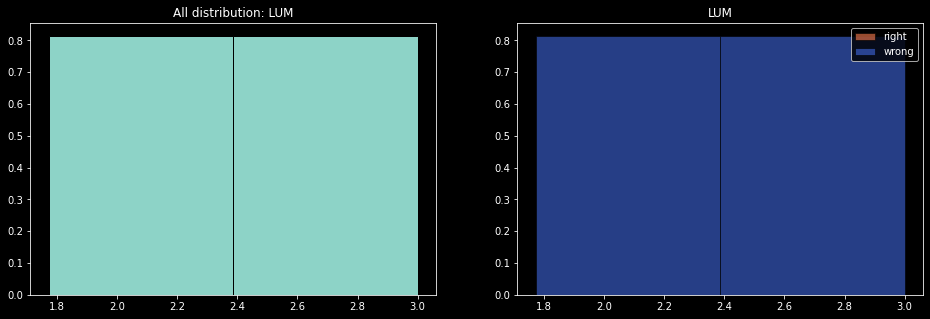

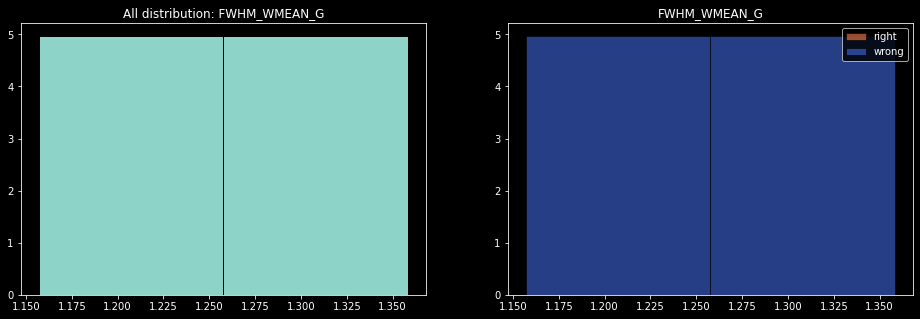

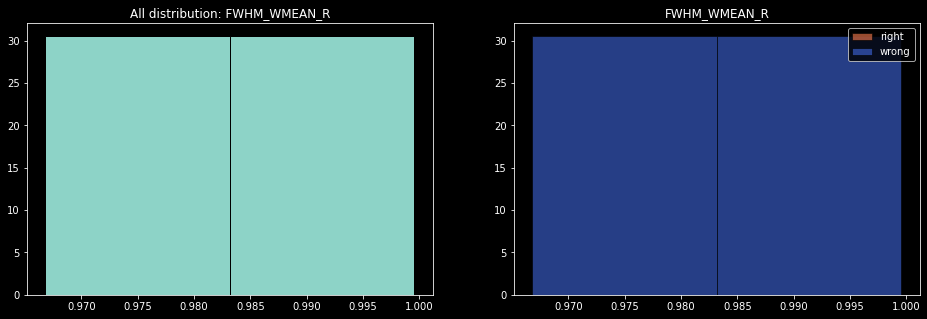

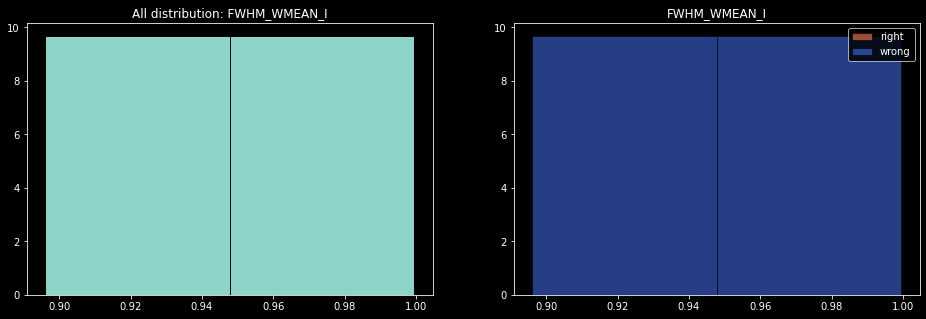

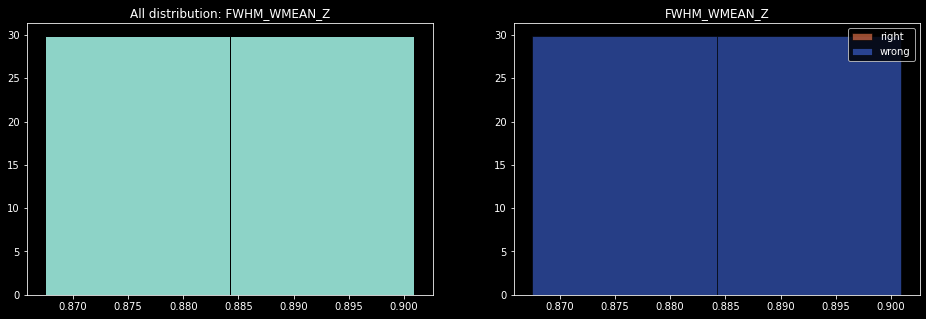

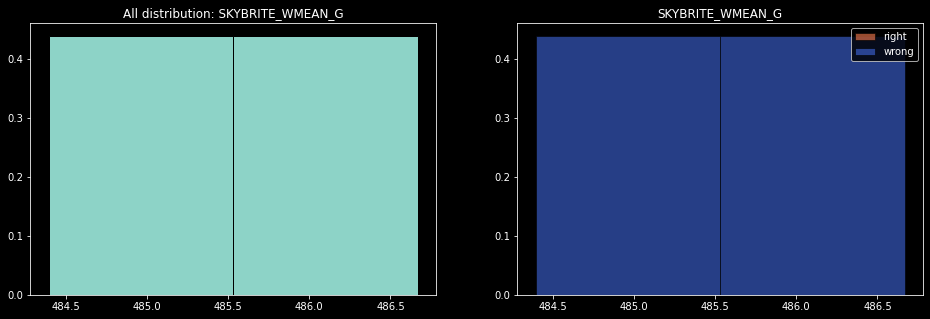

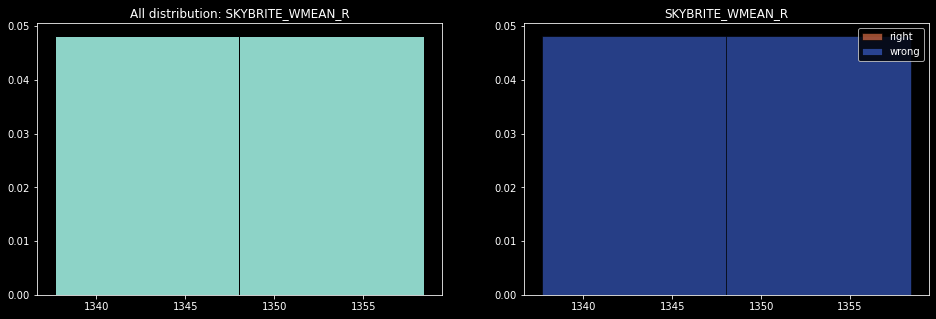

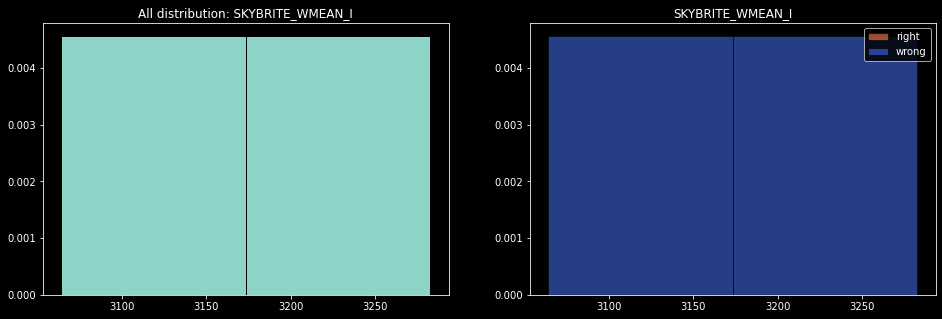

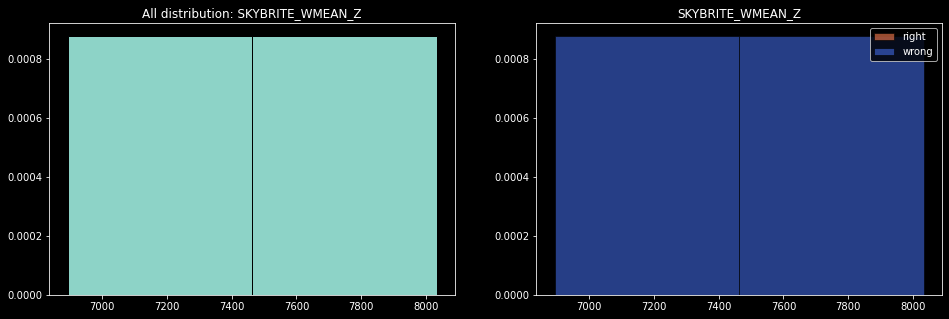

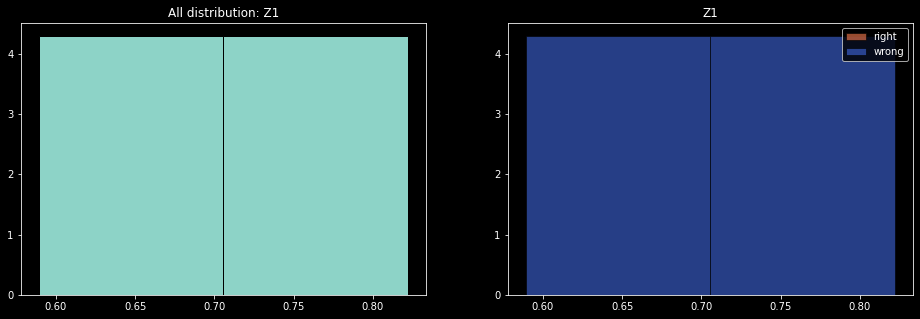

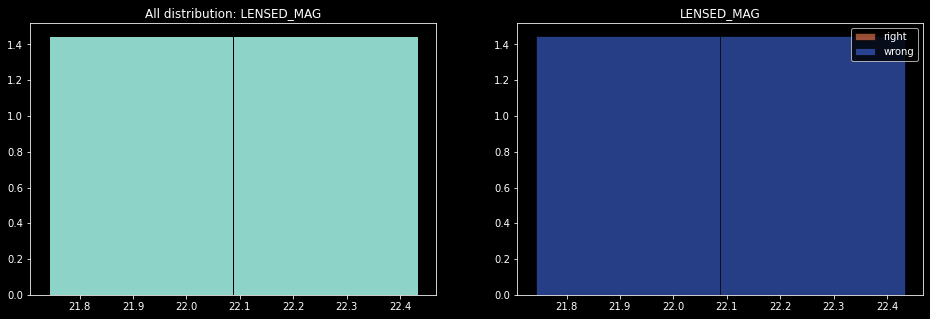

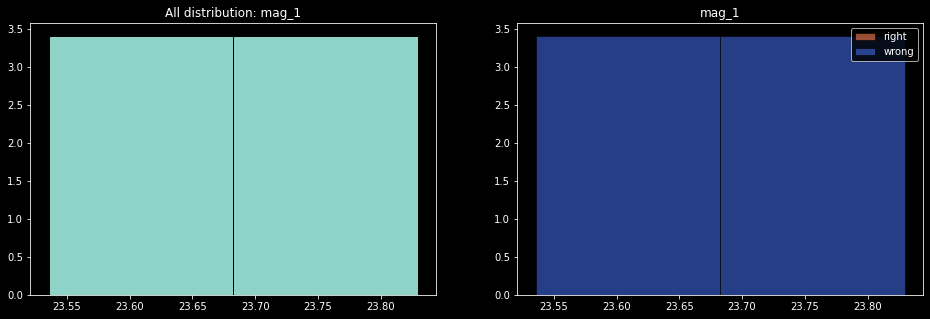

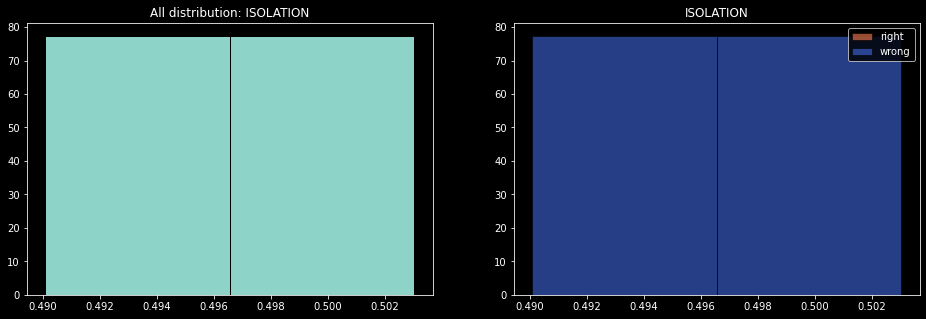

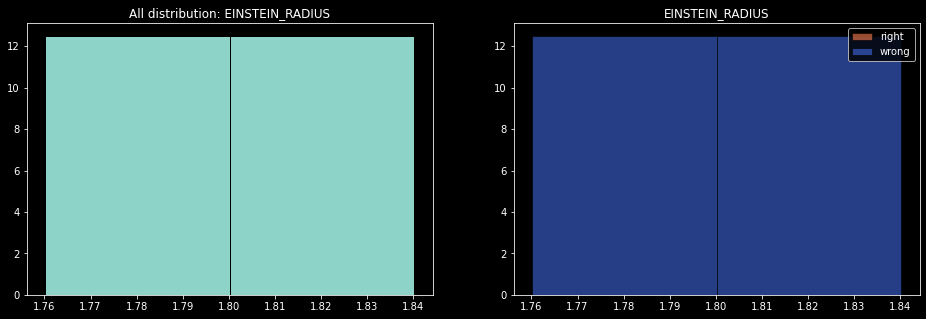

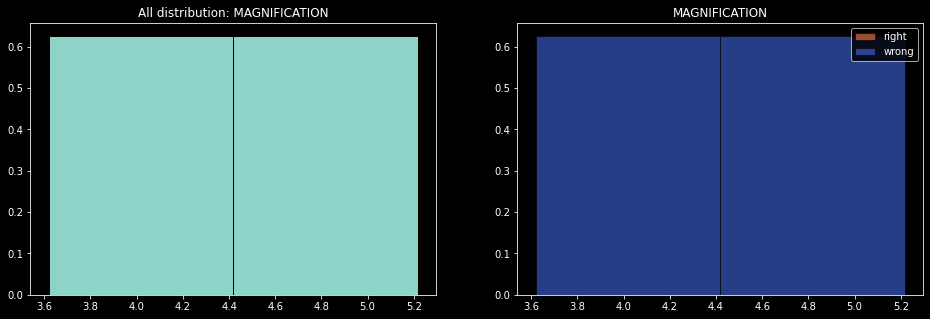

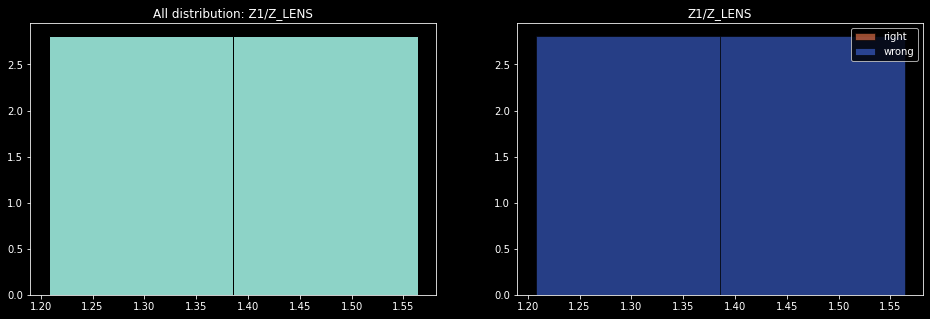

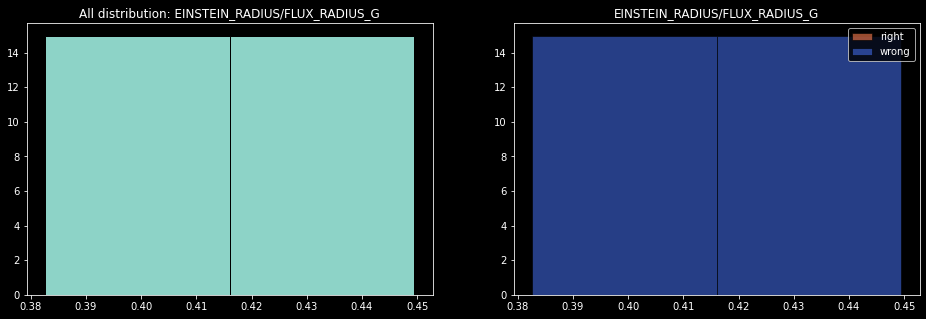

In [25]:
make_all_histos()

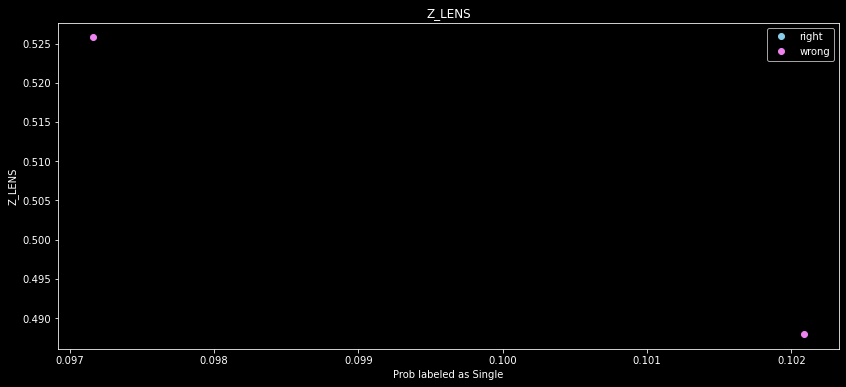

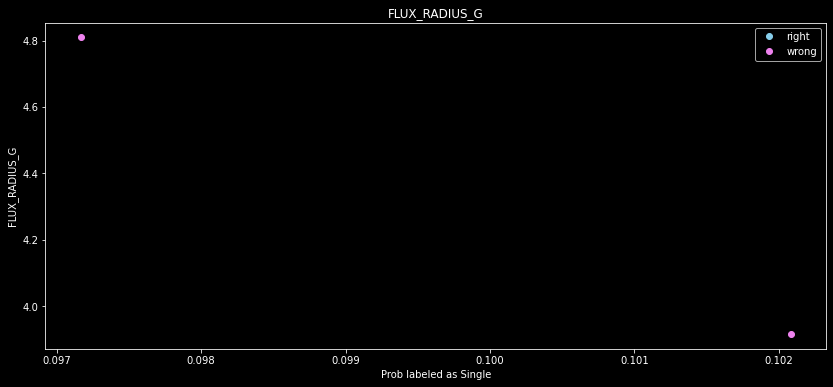

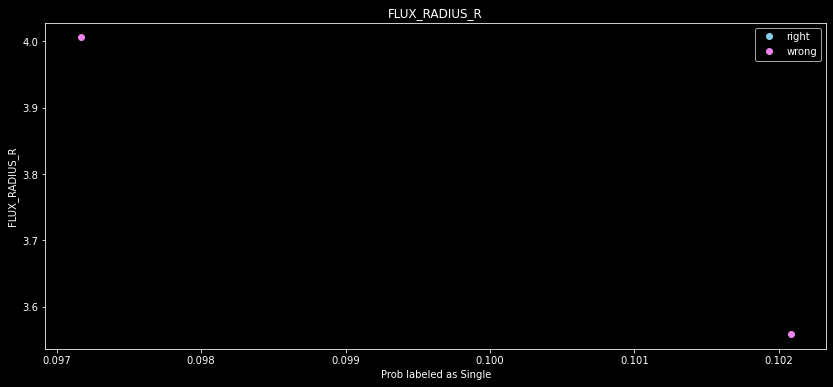

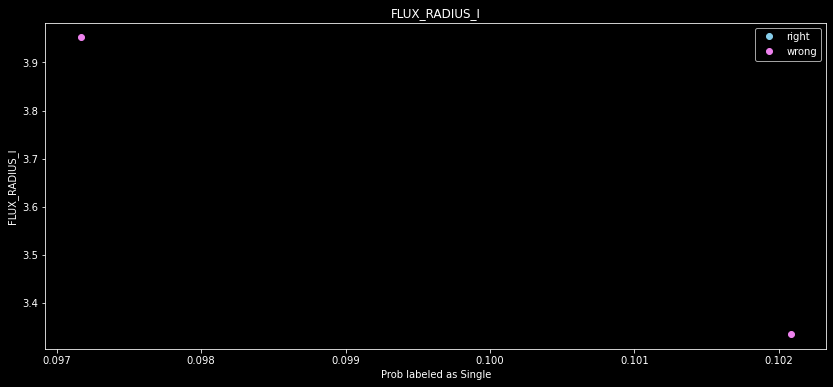

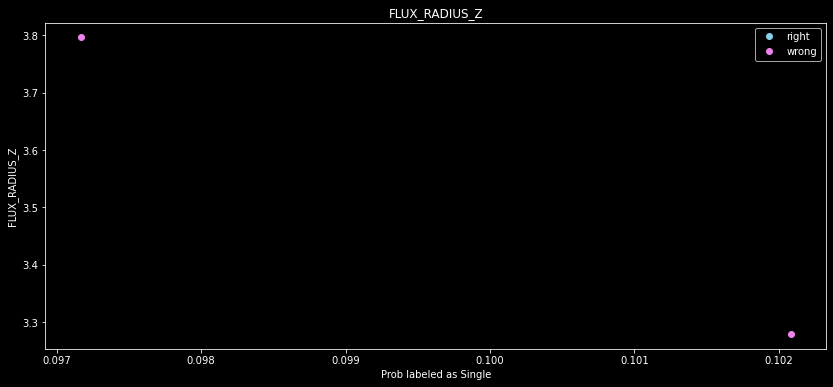

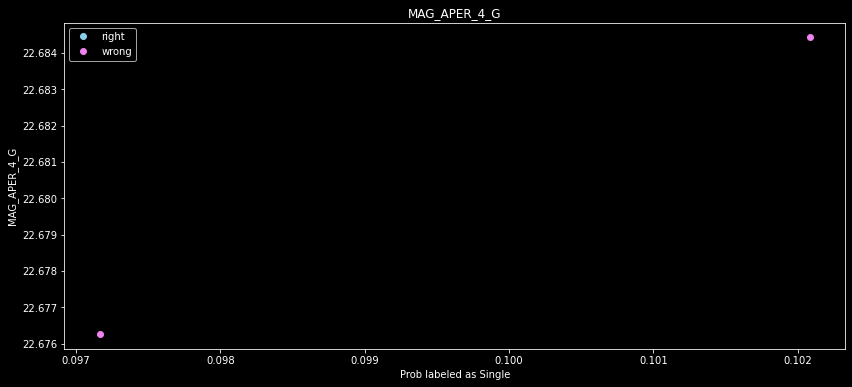

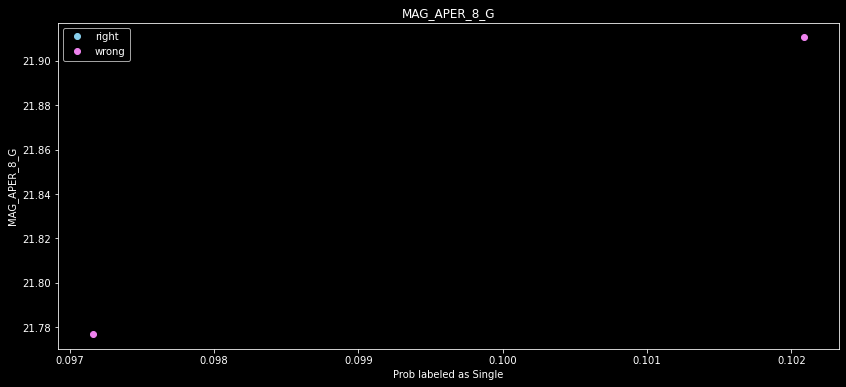

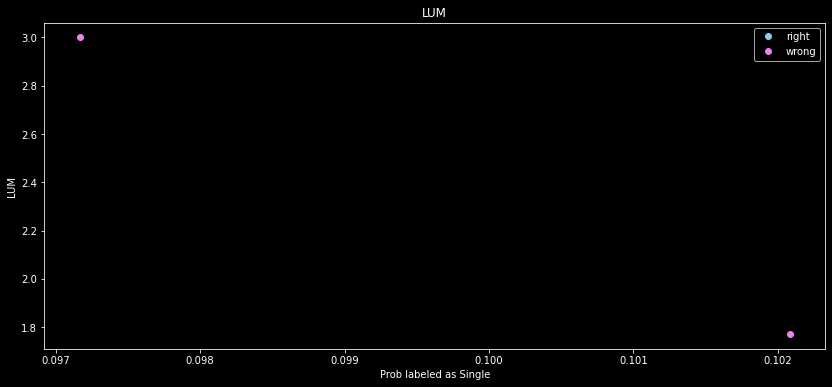

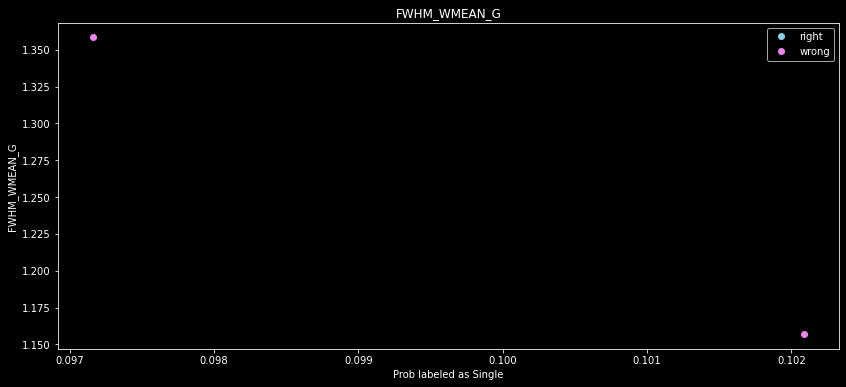

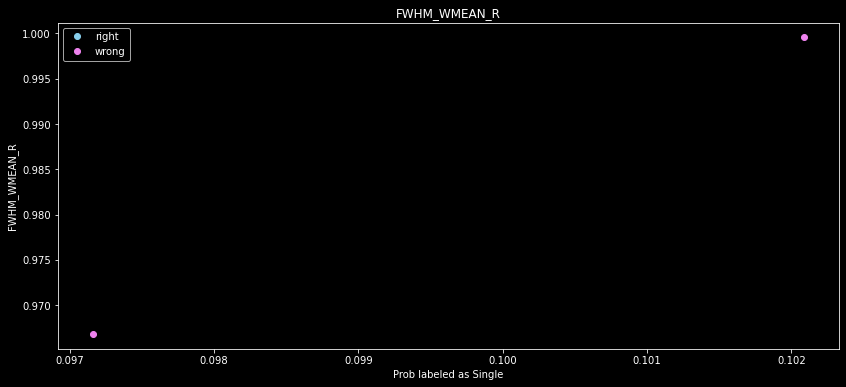

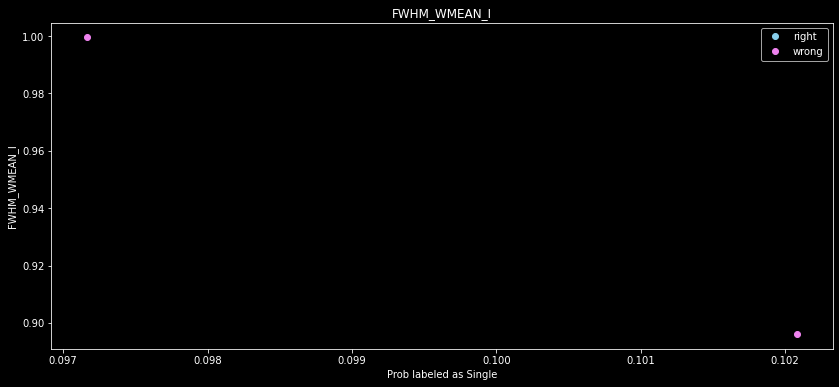

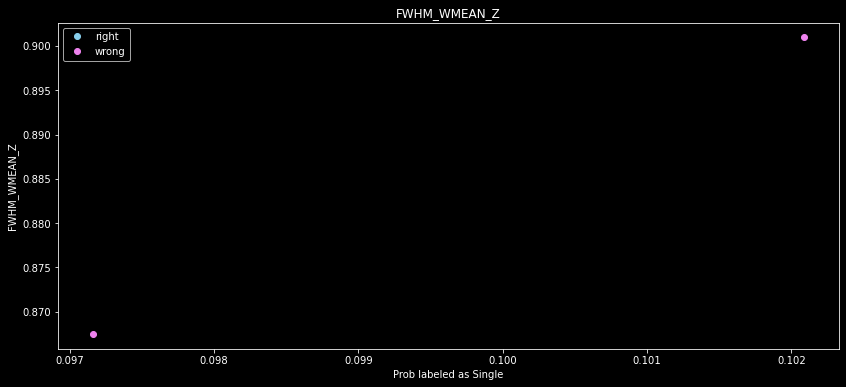

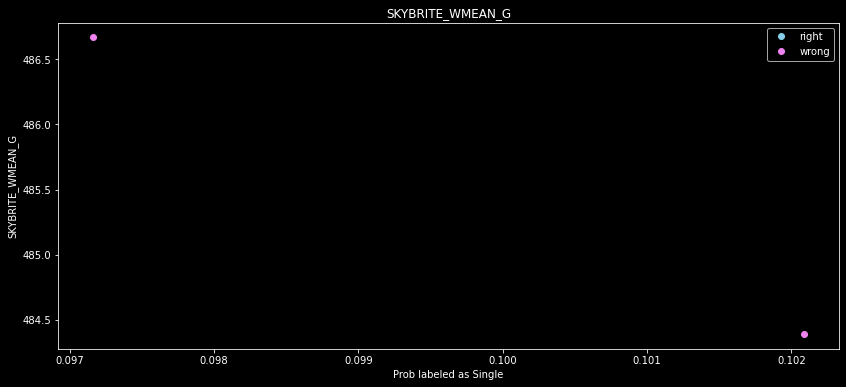

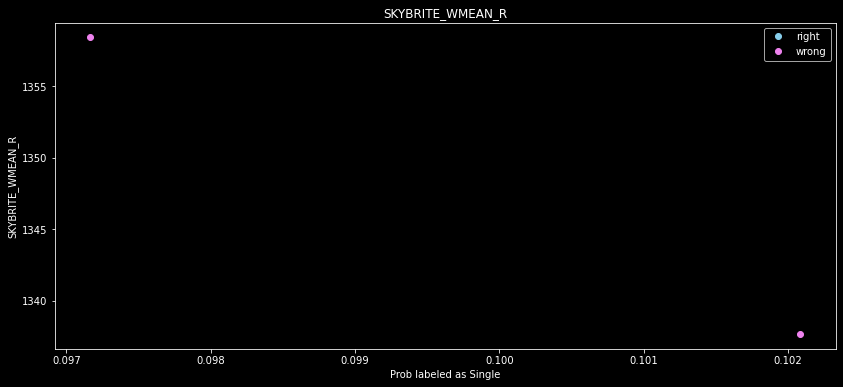

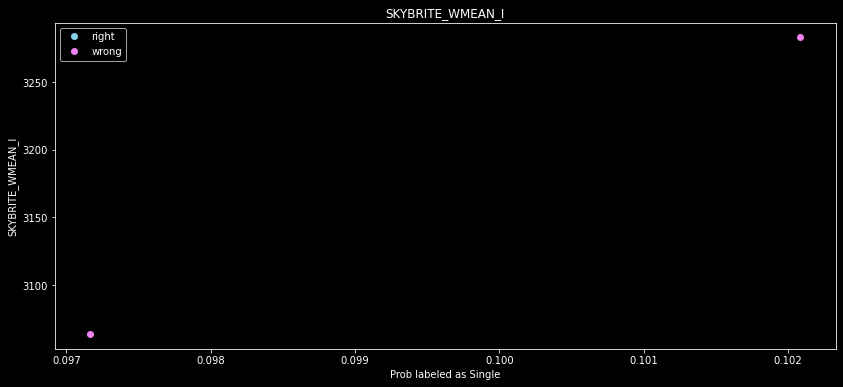

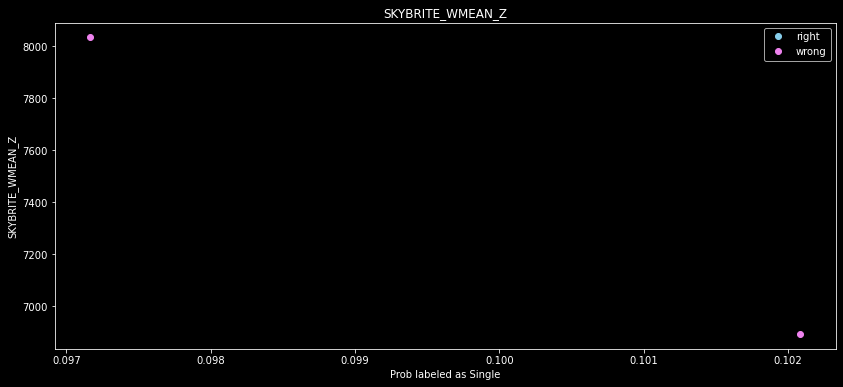

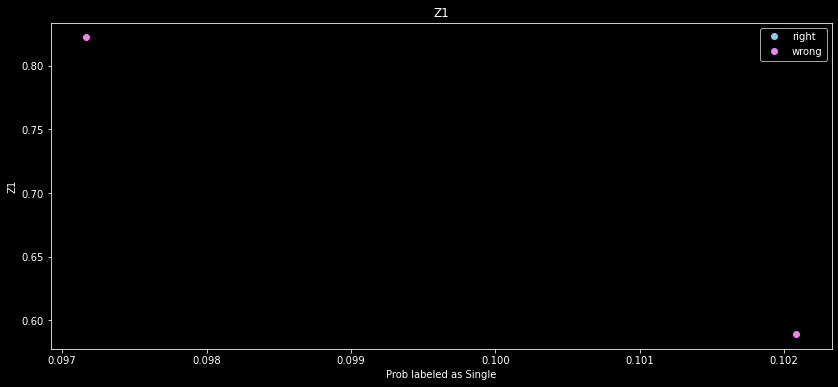

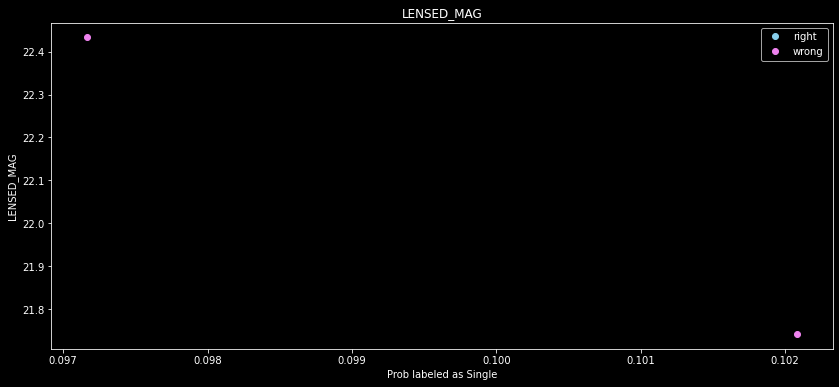

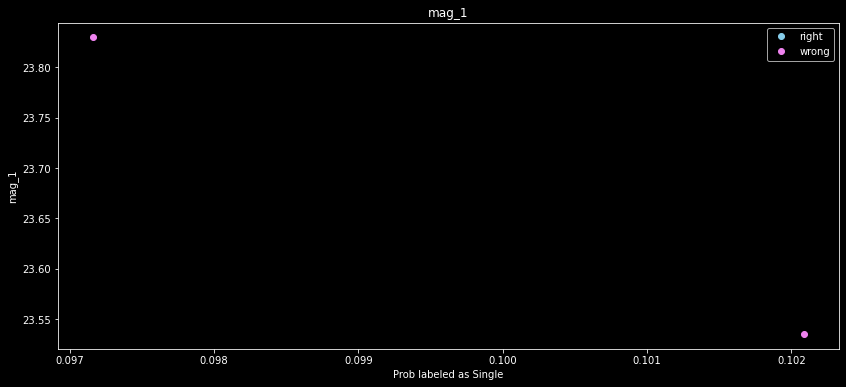

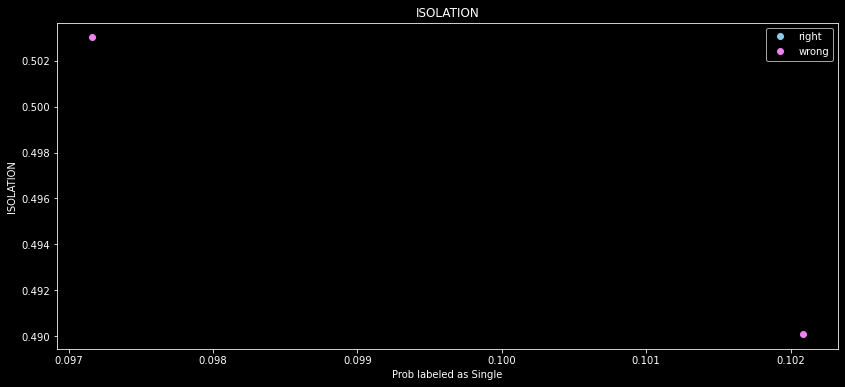

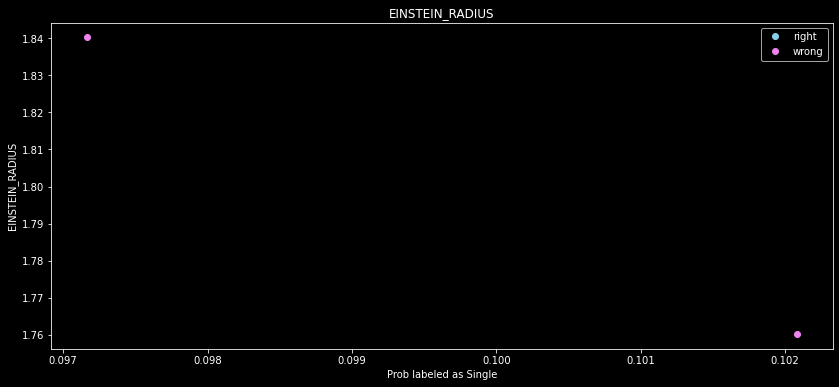

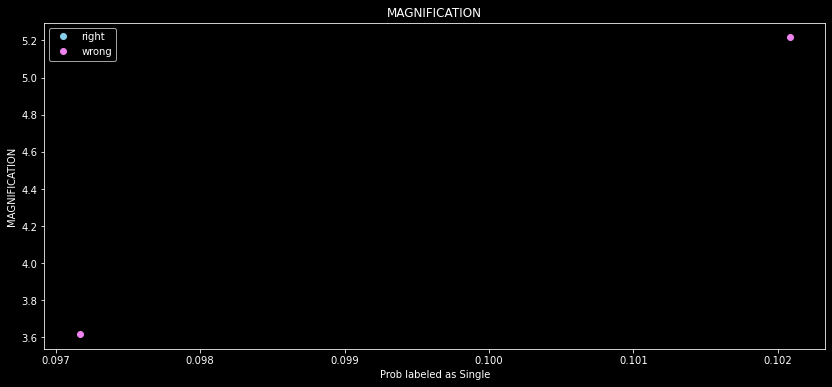

In [26]:
make_all_prob_vs()

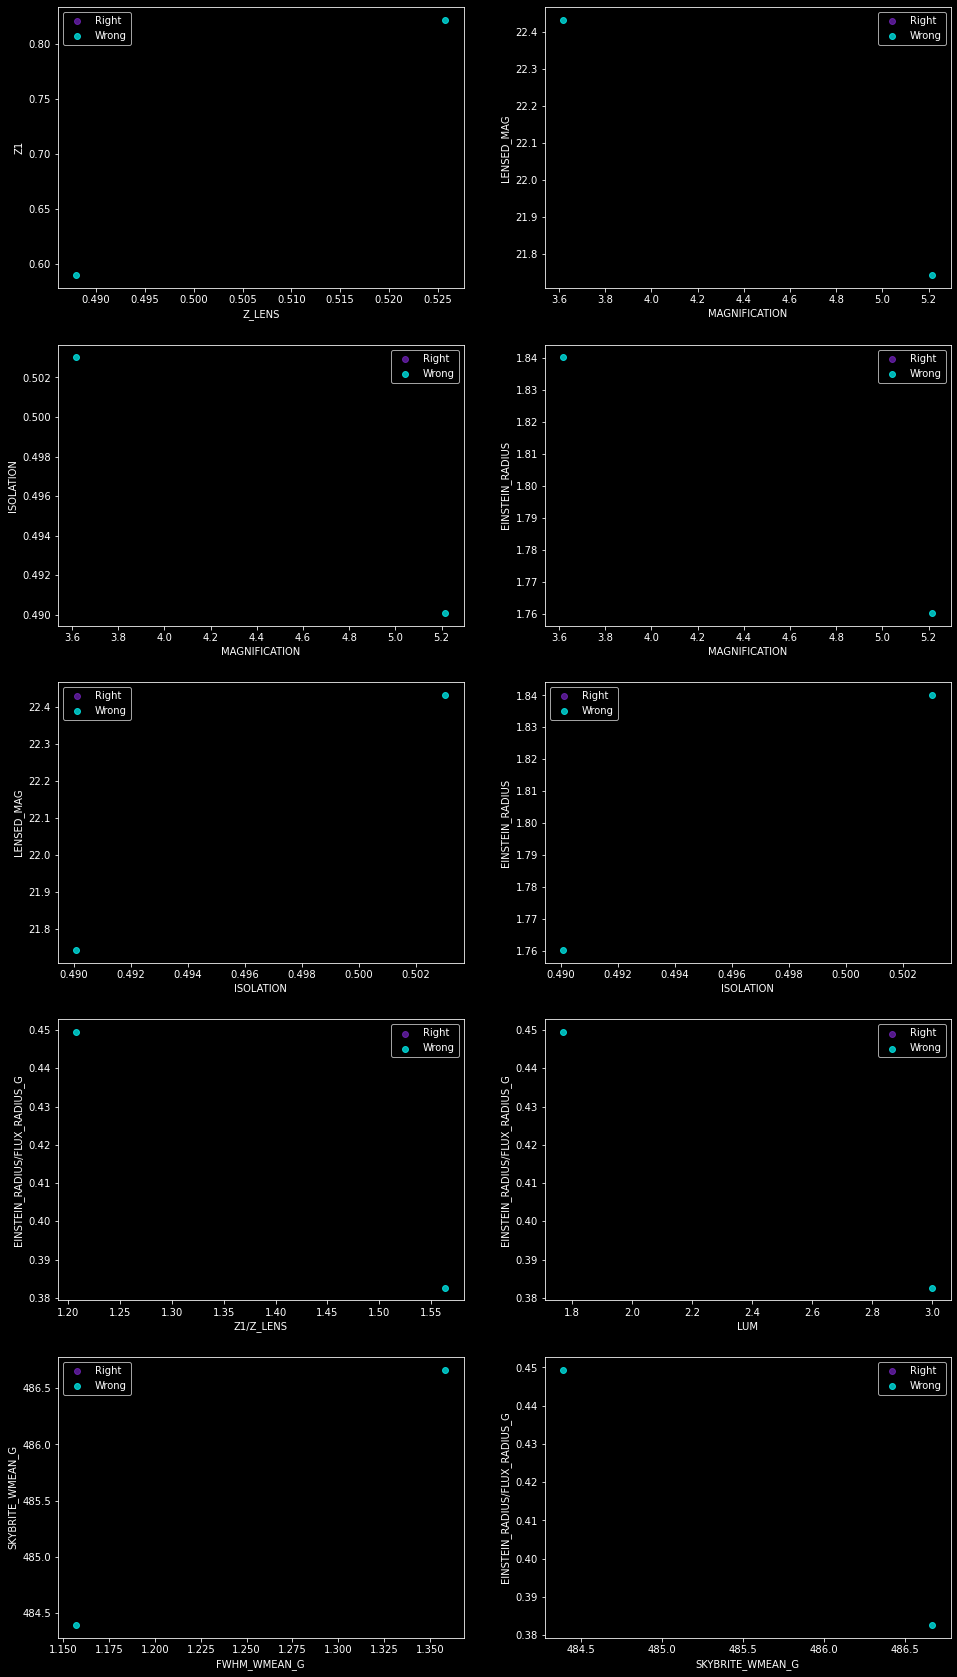

In [27]:
make_plots_correlation()

Wrong negatives
Wrong positives


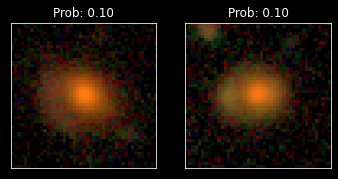

Right positives
Right negatives


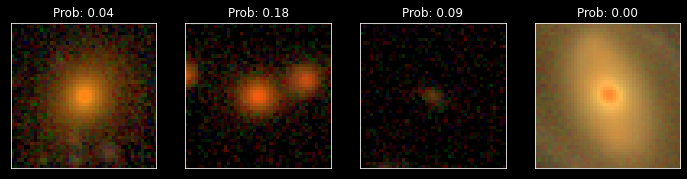

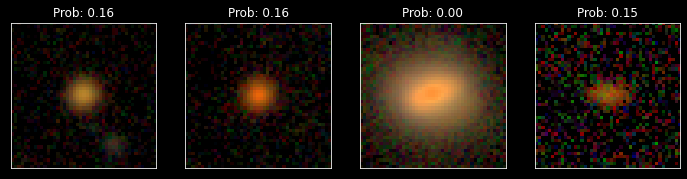

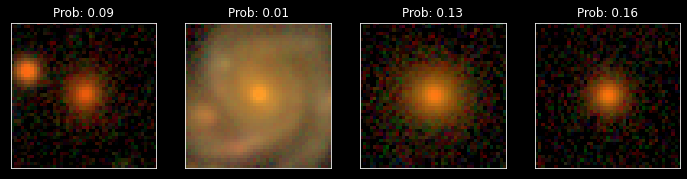

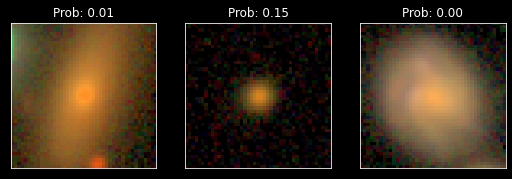

In [28]:
print('Wrong negatives')
make_plot_all(wrong_neg_img, 'Wrong negatives', wrong_neg)
print('Wrong positives')
make_plot_all(wrong_pos_img, 'Wrong positives', wrong_pos)
print('Right positives')
make_plot_all(right_pos_img, 'Right positives', right_pos)
print('Right negatives')
make_plot_all(right_neg_img, 'Right negatives', right_neg)